In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu

In [2]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [3]:
import pandas as pd

df = pd.read_excel('../data/metadata.xlsx', sheet_name=None)

In [4]:
import unet
inputs, labels, pred = unet.run(UNet, df)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
            Conv2d-2         [-1, 64, 512, 512]          36,928
         MaxPool2d-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
            Conv2d-5        [-1, 128, 256, 256]         147,584
         MaxPool2d-6        [-1, 128, 128, 128]               0
            Conv2d-7        [-1, 256, 128, 128]         295,168
            Conv2d-8        [-1, 256, 128, 128]         590,080
         MaxPool2d-9          [-1, 256, 64, 64]               0
           Conv2d-10          [-1, 512, 64, 64]       1,180,160
           Conv2d-11          [-1, 512, 64, 64]       2,359,808
        MaxPool2d-12          [-1, 512, 32, 32]               0
           Conv2d-13         [-1, 1024, 32, 32]       4,719,616
           Conv2d-14         [-1, 1024,

C:\Users\Uni\Documents\DLIVP\dlivp-workspace\venv\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train: ce_loss: 129.536879, dice: 0.541939, loss: 65.039408
val: ce_loss: 322.539978, dice: 0.811624, loss: 161.675797
saving best model
1m 24s
Epoch 1/2
----------
LR 0.0001
train: ce_loss: 116.376046, dice: 0.452639, loss: 58.414342
val: ce_loss: 243.882721, dice: 0.743579, loss: 122.313148
saving best model
1m 28s
Epoch 2/2
----------
LR 0.0001
train: ce_loss: 120.796859, dice: 0.507110, loss: 60.651984
val: ce_loss: 356.782959, dice: 0.834579, loss: 178.808762
1m 30s
Best val loss: 122.313148
(1, 3, 512, 512)


In [12]:
print(inputs.size())

torch.Size([3, 512, 512])


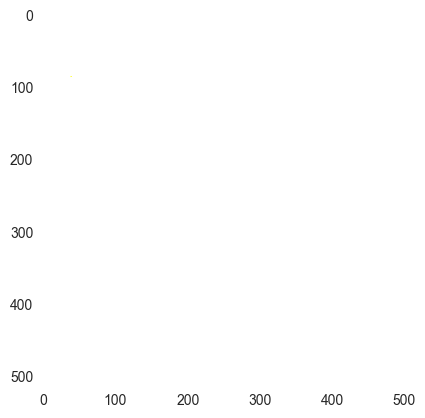

In [21]:
import matplotlib.pyplot as plt
import numpy as np
# maxValue = np.amax(Image)
# minValue = np.amin(Image)
plt.imshow(  np.clip(inputs[0].permute(1, 2, 0), 0 ,1 )  )